Conclusions made for hyperparameters:

For mini-batch learning, having a larger batch size makes training faster, which is to be expected. Performance-wise, batch sizes 16 and 64 have similar performance, while 32 had slightly worse performance. Interestingly, batch sizes 16 and 64 have high noise in its loss graph, while batch size 32 has a more normal loss curve.

Metric-wise, all three optimizers perform about the same. The loss function history looks suspicious because of the extreme noise in the loss graph, but when we viewed the predicted outputs compared to the ground truth data, the predictions look fine. Between the optimizer's predictions, there is almost no visual difference. Out of all the loss graphs, relatively, SGD has the most normal loss graph.

Between the activation functions, their performance are also very similar, but tanh has slightly better MAE and RMSE, so we will keep that as our main activation function.

Other hyperparameter tuning conclusions: First layer having 64 nodes was best, second layer having 16 nodes was best, drop rate of 0.2 was just right (interestingly, drop rate 0.3 yielded very bad results), and having 15% data be validation was best (this can be because towards the end, there is more outliers, so reducing validation leads to outliers having more "weight").

Finally, we tested using our custom weighted MSE, which scales loss up if the y truth is an outlier, but it does not improve our model. This may be because overall, it's still better to handle majority of data than handling outliers

(Final model training is towards end of notebook)
During training "improved" model, it turns out that combining changes does not improve model. Therefore, we will use the "base model", which happens to already have most of the optimal hyperparameters.


In [ ]:
# using Recurrent Neural Network (LSTM)

# data preparation

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import random

# Load data
df = pd.read_csv('merged_data4.csv')
df.drop_duplicates(inplace=True)             # remove duplicate rows
df.dropna(inplace=True)                      # remove any rows with NaN
df = df.reset_index(drop=True)

# Date processing time (make cyclic via sin function)
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = np.sin(2 * np.pi / 7.0 * df['Date'].dt.dayofweek )
df['hour_of_day'] = np.sin(2 * np.pi / 24.0 * df['Date'].dt.hour)
df['month'] = np.sin(2 * np.pi / 12.0 * (df['Date'].dt.month - 1))

# Additional features and target (to help better predict outlier data)
df['AvgPrice_Other_sq'] = df['AveragePrice_OtherStates'] ** 2
df['AvgPrice_Other_3h'] = df['AveragePrice_OtherStates'].diff(periods=3)
# fill the NaN values created at the beginning
df.fillna(0, inplace=True)

features = [
    'forecasted_load',
    'actual_load',
    'day_ahead_lmp',
    'AveragePrice_OtherStates',
    'AvgPrice_Other_sq',
    'AvgPrice_Other_3h',
    'day_of_week',
    'hour_of_day',
    'month',
    'wind_speed_kmh',
    'coco_Clear',
    'coco_Fair',
    'coco_Cloudy',
    'coco_Overcast',
    'coco_Fog',
    'coco_Light_Rain',
    'coco_Rain',
    'coco_Heavy_Rain',
    'coco_Heavy_Rain_Shower',
    'coco_Light_Snow',
    'coco_Snow',
    'coco_Heavy_Snow',
    'coco_Thunderstorm',
    'coco_Sleet',
    'coco_Heavy_Sleet'
]
target = 'actual_lmp'

X = df[features].values
y = df[target].values.reshape(-1, 1)

# Normalize data (important for RNNs)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Define sequence length (how many past steps you want to use)
seq_len = 7  # using past 24 hours - originally 168

# Create time series sequences
X_seq, y_seq = [], []
for i in range(seq_len, len(X_scaled)):
    X_seq.append(X_scaled[i - seq_len:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split into train/evaluation (train will be further split to train and validation)
split = int(0.85 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [ ]:
# Some useful functions to look at results of model
# Used AI to help know how to use history
# Plots graph of loss for train+test per epoch (prob only use for significant experiments cuz it takes up space)
def plot_history(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)

  plt.plot(epochs, loss_values, 'g', label='Training Loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Print eval metrics of model
def print_evaluation(Model):
  # Predictions
  y_pred_scaled = Model.predict(X_test)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  y_true = scaler_y.inverse_transform(y_test)

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f"MAE = {mae:.3f}")
  print(f"MSE = {mse:.3f}")
  print(f"RMSE = {rmse:.3f}")
  print(f"R² = {r2:.3f}")

# Experiment on model's hyper-parameters
def simplify_model_change(l1=64, l2=32, drop=0.2, activation='tanh', split=0.15, num_epochs=20):
  model = Sequential([
      LSTM(l1, activation=activation, return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
      Dropout(drop),
      LSTM(l2, activation=activation),
      Dropout(drop),
      Dense(1)
  ])
  model.compile(optimizer='adam', loss='mse')
  history_relu = model.fit(X_train, y_train,epochs=num_epochs,batch_size=32,validation_split=split)

  # print eval here cuz why not
  print_evaluation(model)

def plot_prediction_vs_actual(Model):
  # 1. Get the corresponding dates for the test set
  # The test data starts after the sequence length and the training split
  test_dates = df['Date'][split + seq_len:].reset_index(drop=True)

  y_pred_scaled = Model.predict(X_test)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  y_true = scaler_y.inverse_transform(y_test)

  y_pred = y_pred.flatten()
  y_true = y_true.flatten()

  # Ensure the lengths match before plotting
  if len(test_dates) != len(y_true):
      print(f"Warning: Length of dates ({len(test_dates)}) does not match length of test data ({len(y_true)}). Plot may be incorrect.")

  # 2. Create the first plot: Actual vs. Predicted
  plt.figure(figsize=(20, 8))
  plt.plot(test_dates, y_true, color='blue', label='Actual Prices')
  plt.plot(test_dates, y_pred, color='red', alpha=0.8, linestyle='--', label='Predicted Prices')
  plt.title('Model Performance: Actual vs. Predicted LMP', fontsize=16)
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('LMP Price', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.show()

  # 3. Create the second plot: Prediction Error (Difference)
  error = y_true - y_pred

  plt.figure(figsize=(20, 8))
  plt.plot(test_dates, error, color='green', label='Prediction Error (Actual - Predicted)')
  plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
  plt.title('Prediction Error Over Time', fontsize=16)
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('Error', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
# Used AI to help create "custom loss" function (to penalize conservative behavior of model)
def weighted_mse(y_true, y_pred):
    # ~4.86% of labeled data are "outliers" (via IQR method)
    # also want to include values close to outliers s
    spike_threshold = 0.90

    weights = K.cast(K.greater(y_true, spike_threshold), 'float32') * 9.0 + 1.0
    return K.mean(weights * K.square(y_true - y_pred))

In [ ]:
# TRAIN BASE MODEL (in which we will modify a single parameter at a time)
# every other parameter is the same as the base's -> easier to make comparisons

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)

print_evaluation(model)
# NOTE THAT EACH RUN, THE RESULTS ARE DIFFERENT -> COMMENTS UNDER EACH TEST WERE WHAT THE OUTPUT WAS ON OUR RUN
# Base model's eval performance
# MAE = 11.123
# MSE = 643.213
# RMSE = 25.362
# R² = 0.246

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9.7179e-04 - val_loss: 2.0974e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.0295e-04 - val_loss: 2.0969e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8558e-04 - val_loss: 2.0485e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.0404e-04 - val_loss: 1.9549e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.6826e-04 - val_loss: 2.2114e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.4809e-04 - val_loss: 1.9896e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.1148e-04 - val_loss: 1.9523e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 2.4973e-04 - val_loss: 1.9515e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.9685e-04 - val_loss: 1.9551e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.2029e-04 - val_loss: 1.9462e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step 

Now we begin tweaking one hyperparameter from the base model and seeing results

In [ ]:
# Experiment on batch size (16 and 64, base = 32)
history_batch16 = model.fit(X_train, y_train,epochs=20,batch_size=16,validation_split=0.15)
print_evaluation(model)
# MAE = 10.484
# MSE = 645.561
# RMSE = 25.408
# R² = 0.243


history_batch64 = model.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.15)
print_evaluation(model)
# MAE = 10.349
# MSE = 621.420
# RMSE = 24.928
# R² = 0.271

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.8572e-04 - val_loss: 1.9521e-04
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.6478e-04 - val_loss: 2.0190e-04
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.8956e-04 - val_loss: 2.1180e-04
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.9111e-04 - val_loss: 1.9338e-04
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2.6951e-04 - val_loss: 1.9499e-04
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.7648e-04 - val_loss: 1.9484e-04
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.4235e-04 - val_loss: 2.0440e-04
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 4.5588e-04 - val_loss: 1.9351e-04
Epoch 9/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.8919e-04 - val_loss: 2.0533e-04
Epoch 10/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.9727e-04 - val_loss: 1.9718e-04
Epoch 11/20
1129/1129 ━━━━━━━━━

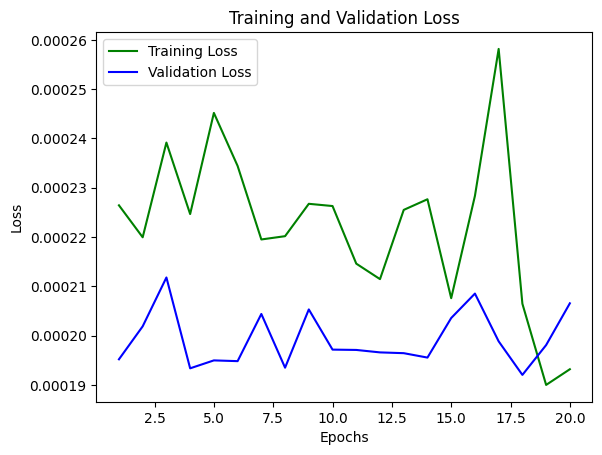

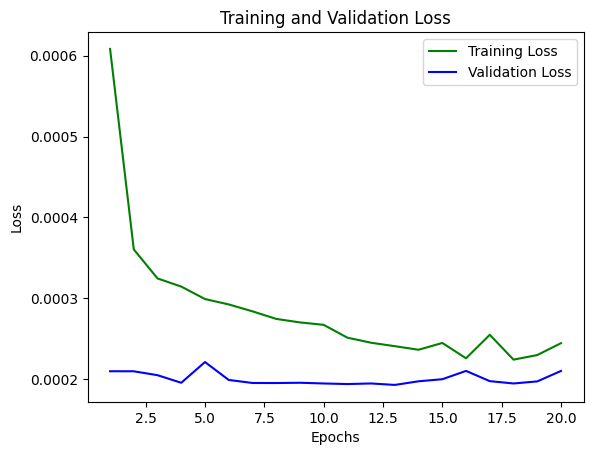

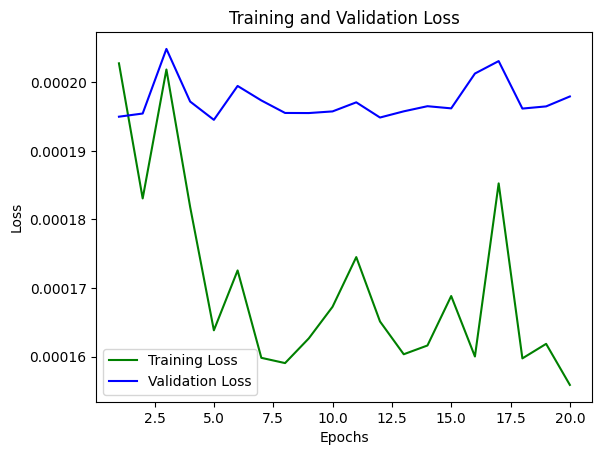

In [ ]:
plot_history(history_batch16)
plot_history(history)
plot_history(history_batch64)

In [ ]:
# Experiment on optimizer (adam, sgd, rmsprop) + learning rate (1e-3, 1e-4)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
history_adam3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15,verbose=1)
print_evaluation(model)
# MAE = 12.106
# MSE = 644.272
# RMSE = 25.383
# R² = 0.244

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history_adam4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.962
# MSE = 632.765
# RMSE = 25.155
# R² = 0.258

# use default recommended momentum value (= 0.9)
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss='mse')
history_sgd3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.593
# MSE = 630.743
# RMSE = 25.115
# R² = 0.260

model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='mse')
history_sgd4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.2)
print_evaluation(model)
# MAE = 10.789
# MSE = 631.473
# RMSE = 25.129
# R² = 0.259

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse')
history_rmsp3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 11.356
# MSE = 637.009
# RMSE = 25.239
# R² = 0.253

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse')
history_rmsp4 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15)
print_evaluation(model)
# MAE = 10.360
# MSE = 630.255
# RMSE = 25.105
# R² = 0.261

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.7660e-04 - val_loss: 1.9820e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.8037e-04 - val_loss: 1.9745e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.5359e-04 - val_loss: 1.9607e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.7469e-04 - val_loss: 2.0485e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.7324e-04 - val_loss: 2.0077e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.3082e-04 - val_loss: 1.9473e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.7365e-04 - val_loss: 1.9548e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.4127e-04 - val_loss: 1.9633e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.0654e-04 - val_loss: 1.9937e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.8533e-04 - val_loss: 1.9402e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

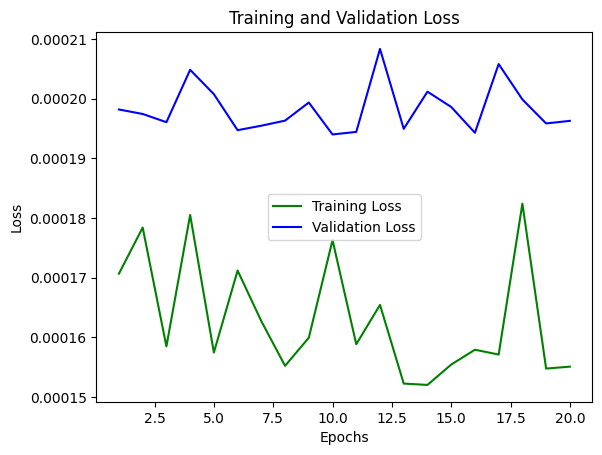

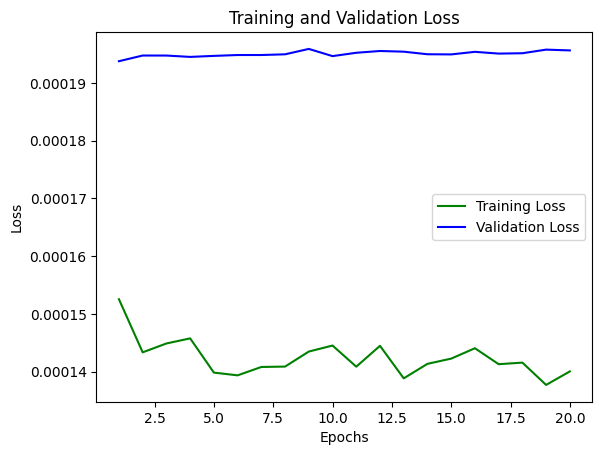

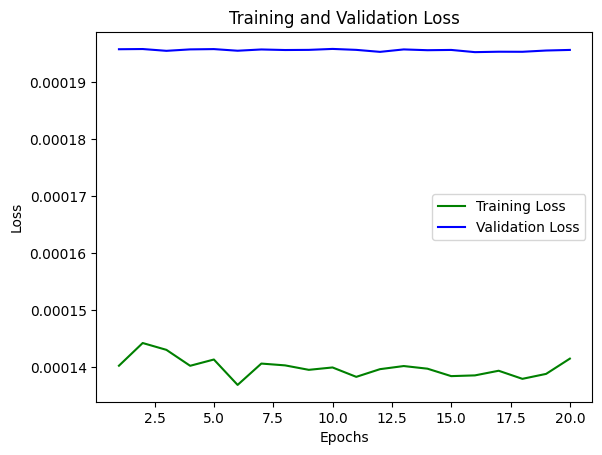

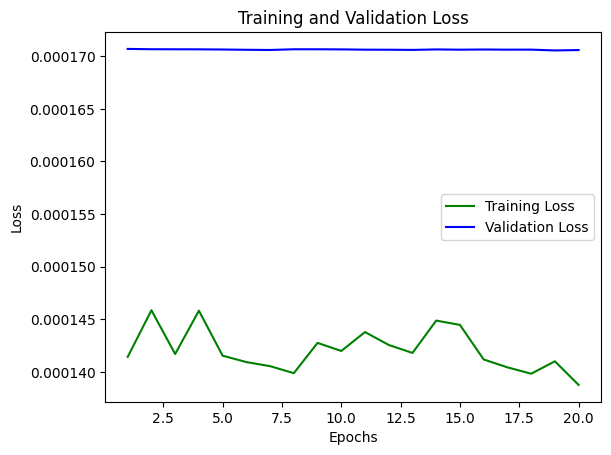

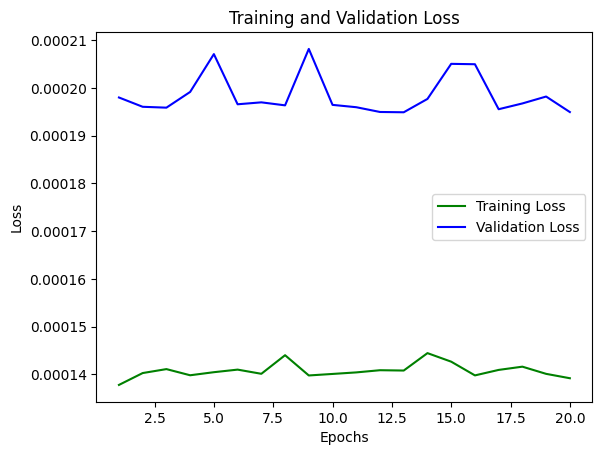

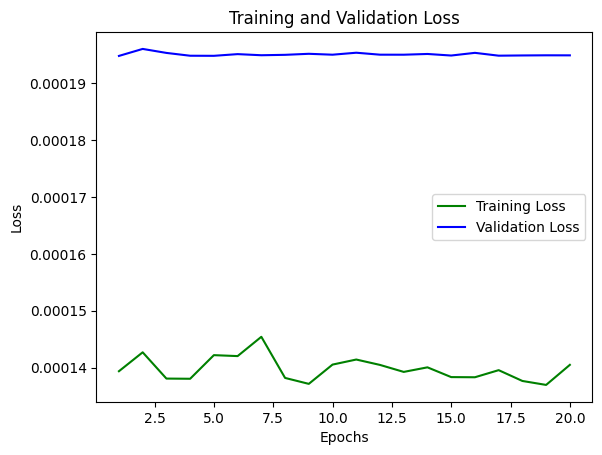

In [ ]:
plot_history(history_adam3)
plot_history(history_adam4)
plot_history(history_sgd3)
plot_history(history_sgd4)
plot_history(history_rmsp3)
plot_history(history_rmsp4)

In [ ]:
## Activation (relu, sigmoid) for each layer
simplify_model_change(activation='relu')
# MAE = 11.245
# MSE = 689.336
# RMSE = 26.255
# R² = 0.192

simplify_model_change(activation='sigmoid')
# MAE = 11.409
# MSE = 729.304
# RMSE = 27.006
# R² = 0.145

## Number of nodes on layers (layer 1 = [32, 64, 128], layer 2 = [16, 32])
simplify_model_change(l1=32)
# MAE = 14.312
# MSE = 675.712
# RMSE = 25.994
# R² = 0.207
simplify_model_change(l1=128)
# MAE = 14.103
# MSE = 789.783
# RMSE = 28.103
# R² = 0.074
simplify_model_change(l2=16)
# MAE = 10.647
# MSE = 641.130
# RMSE = 25.321
# R² = 0.248
simplify_model_change(l1=28, l2=32)
# MAE = 11.308
# MSE = 636.999
# RMSE = 25.239
# R² = 0.253

## Dropout rate (0.1, 0.3)
simplify_model_change(drop=0.1)
# MAE = 13.105
# MSE = 666.110
# RMSE = 25.809
# R² = 0.219
simplify_model_change(drop=0.3)
# MAE = 18.583
# MSE = 842.317
# RMSE = 29.023
# R² = 0.012

## Num epochs (10, 30)
simplify_model_change(num_epochs=10)
# MAE = 13.040
# MSE = 749.844
# RMSE = 27.383
# R² = 0.121
simplify_model_change(num_epochs=30)
# MAE = 13.327
# MSE = 670.616
# RMSE = 25.896
# R² = 0.213
## Split ratio (0.1, 0.3)
simplify_model_change(split=0.1)
# MAE = 19.299
# MSE = 806.171
# RMSE = 28.393
# R² = 0.054
simplify_model_change(split=0.3)
# MAE = 14.056
# MSE = 715.961
# RMSE = 26.757
# R² = 0.160

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 8.1353e-04 - val_loss: 2.0255e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3419e-04 - val_loss: 2.0971e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.7881e-04 - val_loss: 2.1157e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.2228e-04 - val_loss: 2.2908e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.2177e-04 - val_loss: 2.0996e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.9385e-04 - val_loss: 2.0861e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.1008e-04 - val_loss: 2.4630e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.8726e-04 - val_loss: 2.0087e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.9798e-04 - val_loss: 2.0326e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.1944e-04 - val_loss: 2.1847e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.4

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0208 - val_loss: 2.3012e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 8.8364e-04 - val_loss: 2.3949e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.8085e-04 - val_loss: 2.3483e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.5223e-04 - val_loss: 2.5641e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.2744e-04 - val_loss: 2.6024e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.6688e-04 - val_loss: 2.6458e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.2395e-04 - val_loss: 2.7646e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8424e-04 - val_loss: 2.6997e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.0027e-04 - val_loss: 2.7924e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 4.7520e-04 - val_loss: 2.6565e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 3.4778

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0013 - val_loss: 2.2956e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.0051e-04 - val_loss: 2.1078e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.6841e-04 - val_loss: 1.9863e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.7942e-04 - val_loss: 1.9871e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.2427e-04 - val_loss: 2.2493e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.2450e-04 - val_loss: 2.4269e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.1496e-04 - val_loss: 2.1338e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.4435e-04 - val_loss: 1.9507e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.2423e-04 - val_loss: 2.0727e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.1228e-04 - val_loss: 2.1612e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.5931e-04

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0027 - val_loss: 2.2454e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.3111e-04 - val_loss: 2.1858e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.7792e-04 - val_loss: 2.2300e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 3.1368e-04 - val_loss: 2.0182e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2.6385e-04 - val_loss: 2.0054e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.1322e-04 - val_loss: 2.0958e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 3.7640e-04 - val_loss: 2.0393e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 4.0155e-04 - val_loss: 2.0445e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.4901e-04 - val_loss: 2.1652e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.6102e-04 - val_loss: 2.0171e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0018 - val_loss: 2.0728e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 3.8008e-04 - val_loss: 2.1663e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.1841e-04 - val_loss: 1.9782e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 4.3515e-04 - val_loss: 2.1595e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.8280e-04 - val_loss: 2.0069e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.3916e-04 - val_loss: 2.0172e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.1780e-04 - val_loss: 1.9678e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.7443e-04 - val_loss: 1.9942e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.8854e-04 - val_loss: 1.9369e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.4676e-04 - val_loss: 1.9460e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6204

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0013 - val_loss: 2.1323e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.6711e-04 - val_loss: 2.0404e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.0644e-04 - val_loss: 1.9694e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.7145e-04 - val_loss: 2.0132e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.9765e-04 - val_loss: 2.1327e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.3706e-04 - val_loss: 1.9717e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.1562e-04 - val_loss: 2.0708e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.8285e-04 - val_loss: 1.9916e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.5122e-04 - val_loss: 1.9511e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.3457e-04 - val_loss: 2.0358e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.4328

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0012 - val_loss: 2.1786e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.6764e-04 - val_loss: 1.9967e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.5584e-04 - val_loss: 2.0001e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 3.0978e-04 - val_loss: 1.9922e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 2.4425e-04 - val_loss: 2.0074e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.6476e-04 - val_loss: 2.0314e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.4891e-04 - val_loss: 1.9629e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.9633e-04 - val_loss: 2.0424e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.0788e-04 - val_loss: 1.9793e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 2.1141e-04 - val_loss: 2.0015e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0018 - val_loss: 2.2456e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.7905e-04 - val_loss: 2.0134e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8565e-04 - val_loss: 2.1212e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.3408e-04 - val_loss: 2.0638e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6304e-04 - val_loss: 2.1255e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.1527e-04 - val_loss: 2.1549e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.8242e-04 - val_loss: 2.0068e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.8692e-04 - val_loss: 2.0285e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.6660e-04 - val_loss: 2.0166e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.5179e-04 - val_loss: 1.9160e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.1436e

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0021 - val_loss: 2.0653e-04
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.5229e-04 - val_loss: 2.0830e-04
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 3.2878e-04 - val_loss: 2.0617e-04
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.4279e-04 - val_loss: 3.1316e-04
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.5100e-04 - val_loss: 1.9822e-04
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.5976e-04 - val_loss: 1.9749e-04
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.0938e-04 - val_loss: 1.9482e-04
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.3933e-04 - val_loss: 1.9406e-04
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.0463e-04 - val_loss: 1.9106e-04
Epoch 10/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.1084e-04 - val_loss: 1.9760e-04
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE = 12.147
MSE = 730.5

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0012 - val_loss: 2.0651e-04
Epoch 2/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.9879e-04 - val_loss: 2.0338e-04
Epoch 3/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.8894e-04 - val_loss: 1.9825e-04
Epoch 4/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.7028e-04 - val_loss: 2.0042e-04
Epoch 5/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 3.8496e-04 - val_loss: 2.1037e-04
Epoch 6/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.5769e-04 - val_loss: 1.9784e-04
Epoch 7/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.0430e-04 - val_loss: 2.2015e-04
Epoch 8/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.8826e-04 - val_loss: 1.9586e-04
Epoch 9/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.3533e-04 - val_loss: 2.0577e-04
Epoch 10/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.8432e-04 - val_loss: 2.0744e-04
Epoch 11/30
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.94

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0012 - val_loss: 2.3296e-04
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3830e-04 - val_loss: 2.3846e-04
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.9034e-04 - val_loss: 2.1764e-04
Epoch 4/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.6825e-04 - val_loss: 2.2264e-04
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.7030e-04 - val_loss: 2.2108e-04
Epoch 6/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.1909e-04 - val_loss: 2.1777e-04
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6629e-04 - val_loss: 2.3247e-04
Epoch 8/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.9383e-04 - val_loss: 2.1919e-04
Epoch 9/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.3322e-04 - val_loss: 2.2849e-04
Epoch 10/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.3115e-04 - val_loss: 2.2430e-04
Epoch 11/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.5008

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0015 - val_loss: 2.3665e-04
Epoch 2/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 4.3836e-04 - val_loss: 2.1348e-04
Epoch 3/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.0255e-04 - val_loss: 1.6646e-04
Epoch 4/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.8358e-04 - val_loss: 1.6673e-04
Epoch 5/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.2580e-04 - val_loss: 1.6337e-04
Epoch 6/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.9306e-04 - val_loss: 1.6989e-04
Epoch 7/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.9239e-04 - val_loss: 1.6432e-04
Epoch 8/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.3415e-04 - val_loss: 1.5969e-04
Epoch 9/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.8045e-04 - val_loss: 1.5547e-04
Epoch 10/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.0223e-04 - val_loss: 1.8349e-04
Epoch 11/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.3

In [ ]:
# test to see if weighted_mse helps
model.compile(optimizer=Adam(learning_rate=1e-3), loss=weighted_mse)
history_adam3 = model.fit(X_train, y_train,epochs=20,batch_size=32,validation_split=0.15,verbose=1)
print_evaluation(model)
# MAE = 10.474
# MSE = 629.329
# RMSE = 25.086
# R² = 0.262

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.9906e-04 - val_loss: 1.9702e-04
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1.4367e-04 - val_loss: 1.9751e-04
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.9718e-04 - val_loss: 1.9576e-04
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.8680e-04 - val_loss: 1.9606e-04
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.7949e-04 - val_loss: 1.9500e-04
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.9409e-04 - val_loss: 1.9682e-04
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.7512e-04 - val_loss: 1.9825e-04
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.3781e-04 - val_loss: 1.9669e-04
Epoch 9/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.5099e-04 - val_loss: 1.9595e-04
Epoch 10/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.4503e-04 - val_loss: 1.9943e-04
Epoch 11/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/ste

In [ ]:
# Training hyperparameter-tuned model

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss=weighted_mse)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)

print_evaluation(model)
# Original base model's eval performance
# MAE = 11.123
# MSE = 643.213
# RMSE = 25.362
# R² = 0.246

# Fine-tuned base model's eval performance (w/ custom mse)
# THIS MODEL IS NOT GOOD
# MAE = 16.856
# MSE = 946.810
# RMSE = 30.770
# R² = -0.110

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_len, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(16, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss='mse')

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    verbose=1
)

# Fine-tuned model without custom mse)
# MAE = 10.360
# MSE = 627.421
# RMSE = 25.048
# R² = 0.264

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ee4a2569ee0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


 64/565 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0112

KeyboardInterrupt: 